# Assignment 2
## ISPR 23/24, third midterm
### by Andrea Marino (matr. 561935)

### Preliminary stuff

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from PIL import Image              # Python Image Library

from typing import List, Tuple

In [2]:
if(colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount("/content/drive")
    BASE_PATH = "drive/MyDrive/ISPR/Compitini ISPR/Terzo Compitino/"
    sys.path.insert(0,BASE_PATH)
    #os.chdir(BASE_PATH)
    #!pip install -U torch           # update PyTorch
    #!pip install -U torchvision     # update torchvision
    !pip install -U optuna           # update optuna
else:
    BASE_PATH = ""


In [3]:
import torch
import torch.nn.functional as F
from torch import nn

import optuna

Let's also set PyTorch's seed to a fixed value, for reproducibility but also to get the same splits in the datasets we're going to create

In [4]:
torch.manual_seed(42)

Finally, we define the device.

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Data, Dataset and Dataloaders

Since I already used the dataset for the first assignment, I don't need to download it again. I just have to fetch it from the right directory (in a way that deals with both Colab and my local install)

In [6]:
HORSE_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/horse/")
MASK_PATH = os.path.join(BASE_PATH,"../Primo Compitino/weizmann_horse_db/mask/")

HORSE_PATH, MASK_PATH

('../Primo Compitino/weizmann_horse_db/horse/',
 '../Primo Compitino/weizmann_horse_db/mask/')

We now need to create the class for the dataset, as required by PyTorch.

We can also apply transformations on our data. The principal transformation worth talking about has to deal with the batch size and the shape of the images. 

If in our `DataLoader`s the batch size is set to be greater than 1, then the images have to be of the same shape (height * width), otherwise the associated tensors can't be stacked in a single batch tensor. This is unfortunate, we can deal with it in three ways:
1. Always online learning algorithm (aka batch_size=1)
2. Resize the image
3. Add a padding of zeros to the smaller images, to bring them all to the same size as the bigger image in the dataset (and then let the model deal with the extra padding).

All three options are interesting for their own reasons, so writing a more general code that allows one to apply each of the ideas is worthwhile.

The first option allows to assess the model's performance on images of different sizes, an interesting challenge for sure. The second option is the most promising and most powerful one, as torchvision's tools seems to do a good job at resizing both the images and the mask, upon preliminary checking. The third option is pretty rough, but it might be interesting to see how the model performs in this case.

In [7]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import Lambda

class HorseDataset(Dataset):
    def __init__(self, 
                 image_path=HORSE_PATH,
                 mask_path=MASK_PATH,
                 transform=None, # normalize pixel values
                 target_transform=None,):
        self.img_dir = image_path
        self.mask_dir = mask_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        # We know that the answer is 327 but let's make it
        # more general and structured
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path, mask_path = self._horsePath(idx+1)
        img = read_image(img_path)      
        mask = read_image(mask_path)  
        img  = img.float()          # convert to float
        mask = mask.long()          # convert to long
        # transforms given as input
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            mask = self.target_transform(mask)
        # standard transforms
        img = img/torch.max(img)    # normalize pixel values
        #mask[mask>0] = 1.0          # set all non-zero values to 1
        return img, mask
    
    def __iter__(self):
        for i in range(len(self)):
            yield self.__getitem__(i)    
    
    def _horsePath(self, h:int):
        '''
        Returns the path to the horse image
        whose number (in the filename) is h
        '''
        number = "0"*(2-int(np.log10(h)))+str(h)
        imgname = "horse" + number + ".png"
        img_path = self.img_dir + imgname
        mask_path = self.mask_dir + imgname
        return img_path, mask_path

To apply the transformations as described, we may need the height and width of the biggest and smallest images in the dataset.

In [8]:
plain_dataset = HorseDataset()

MAX, MIN = (0,0), (np.inf,np.inf)
biggest, smallest = -1,-1

for i, (img, _) in enumerate(plain_dataset,start=1):
    img_h, img_w = tuple(img.shape[1:])
    if img_h*img_w > MAX[0]*MAX[1]:
        MAX = (img_h, img_w)
        biggest = i
    if img_h*img_w < MIN[0]*MIN[1]:
        MIN = (img_h, img_w)
        smallest = i

print(f"The biggest image is horse {biggest}, of size {MAX[0]}x{MAX[1]}")
print(f"The smallest image is horse {smallest}, of size {MIN[0]}x{MIN[1]}")

The biggest image is horse 65, of size 960x1280
The smallest image is horse 16, of size 148x231


In [9]:
image0, mask0 = plain_dataset[0]
print(f"Image shape: {image0.shape}, mask shape: {mask0.shape}")
print(f"Image type: {image0.dtype}, mask type: {mask0.dtype}")
print(f"Image values range: {torch.min(image0).item()} - {torch.max(image0).item()}")
print(f"Mask values range: {torch.min(mask0).item()} - {torch.max(mask0).item()}")

Image shape: torch.Size([3, 590, 800]), mask shape: torch.Size([1, 590, 800])
Image type: torch.float32, mask type: torch.int64
Image values range: 0.0 - 1.0
Mask values range: 0 - 1


#### Horse dataset of unchanged images

We create a dataset following the first option.

We can use the `random_split` to create the training set and the test set. 

20% of the whole dataset is held out as test set. I chose this approach over cross-validation to alleviate the computational burden.

In [10]:
from torch.utils.data import random_split

# Create the developement and test datasets
train_size = int(0.8 * len(plain_dataset))
test_size = len(plain_dataset) - train_size

training_plain_dataset, test_plain_dataset = random_split(plain_dataset, [train_size, test_size])

Now we can create the DataLoaders for the training and test data, using batch size of 1 since we applied no transformation

In [11]:
from torch.utils.data import DataLoader

# Attenzione:
BATCH_SIZE = 1

train_plain_dataloader = DataLoader(training_plain_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_plain_dataloader = DataLoader(test_plain_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
print(f"Training: n° images is {len(train_plain_dataloader.dataset)}, n° of minibatches is: {len(train_plain_dataloader)}")
print(f"Test: n° images is {len(test_plain_dataloader.dataset)}, n° of minibatches is: {len(test_plain_dataloader)}")

for X, y in train_plain_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype)
    print("Shape of y: [N, C, H, W]", y.shape, y.dtype)
    break

for i, (X, y) in enumerate(train_plain_dataloader):
    assert torch.min(y) >= 0 and torch.max(y) <= 1, f"Error at minibatch {i}: targets should be in [0, 1] for BCELoss. Found min {torch.min(y)} and max {torch.max(y)}"
    assert torch.min(X) >= 0 and torch.max(X) <= 1, f"Error at minibatch {i}: inputs should be in [0, 1]. Found min {torch.min(X)} and max {torch.max(X)}"


Training: n° images is 261, n° of minibatches is: 261
Test: n° images is 66, n° of minibatches is: 66
Shape of X [N, C, H, W]:  torch.Size([1, 3, 207, 335]) torch.float32
Shape of y: [N, C, H, W] torch.Size([1, 1, 207, 335]) torch.int64


#### Horse dataset of resized images

Let's see how the `HorseDataset` class allows us to create a dataset of resized images.

In [13]:
from torchvision.transforms import Resize

#resize_transform = lambda h,w: Lambda(lambda X: Resize((h,w))(X))
def resize_transform(height:int, width:int):
    return Lambda(lambda X: Resize((height,width))(X))

# We can resize to the smallest, or choose any other size
h, w = 360, 480

dataset_resized = HorseDataset(transform=resize_transform(h,w), 
                              target_transform=resize_transform(h,w))

In [14]:
image0, mask0 = dataset_resized[0]
print(f"Image shape: {image0.shape}, mask shape: {mask0.shape}")
print(f"Image type: {image0.dtype}, mask type: {mask0.dtype}")
print(f"Image values range: {torch.min(image0).item()} - {torch.max(image0).item()}")
print(f"Mask values range: {torch.min(mask0).item()} - {torch.max(mask0).item()}")

Image shape: torch.Size([3, 360, 480]), mask shape: torch.Size([1, 360, 480])
Image type: torch.float32, mask type: torch.int64
Image values range: 0.0 - 1.0
Mask values range: 0 - 1


DataLoader creation:


In [15]:
training_resized_dataset, test_resized_dataset = random_split(dataset_resized, [train_size, test_size])

BATCH_SIZE = 4

train_resized_dataloader = DataLoader(training_resized_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_resized_dataloader = DataLoader(test_resized_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
print(f"Training: n° images is {len(train_resized_dataloader.dataset)}, n° of minibatches is: {len(train_resized_dataloader)}")
print(f"Test: n° images is {len(test_resized_dataloader.dataset)}, n° of minibatches is: {len(test_resized_dataloader)}")

for X, y in train_resized_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype)
    print("Shape of y: [N, C, H, W]", y.shape, y.dtype)
    break

for i, (X, y) in enumerate(train_resized_dataloader):
    #assert torch.min(y) >= 0 and torch.max(y) <= 1, f"Error at minibatch {i}: targets should be in [0, 1] for BCELoss. Found min {torch.min(y)} and max {torch.max(y)}"
    assert torch.unique(y).tolist() == [0,1], f"Error at minibatch {i}: targets should be binary (for CrossEntropyLoss). Found {torch.unique(y).tolist()}" 
    assert torch.min(X) >= 0 and torch.max(X) <= 1, f"Error at minibatch {i}: inputs should be in [0, 1]. Found min {torch.min(X)} and max {torch.max(X)}"

Training: n° images is 261, n° of minibatches is: 66
Test: n° images is 66, n° of minibatches is: 17
Shape of X [N, C, H, W]:  torch.Size([4, 3, 360, 480]) torch.float32
Shape of y: [N, C, H, W] torch.Size([4, 1, 360, 480]) torch.int64


#### Horse dataset of padded images

Lastly, we create a dataset of padded images using the `HorseDataset` class.

Instead of passing a fixed amount of padding to the transformation, we pass it the target height and width of the image.

In [17]:
from torchvision.transforms import Pad

#pad_transform = lambda target_h, target_w: Lambda(lambda X: Pad((X.shape[1]-target_h, X.shape[2]-target_w), fill=0)(X))
def pad_transform(target_h:int, target_w:int):
    return Lambda(lambda X: Pad((target_h-X.shape[1], target_w-X.shape[2]), fill=0)(X))

h, w = MAX

dataset_padded = HorseDataset(transform=pad_transform(h,w), 
                              target_transform=pad_transform(h,w))

# Check that things are ok

DataLoader creation:

In [18]:
training_padded_dataset, test_padded_dataset = random_split(dataset_padded, [train_size, test_size])

BATCH_SIZE = 4

train_padded_dataloader = DataLoader(training_padded_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_padded_dataloader = DataLoader(test_padded_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
# Lasciamo perdere per ora va

#print(f"Training: n° images is {len(train_padded_dataloader.dataset)}, n° of minibatches is: {len(train_padded_dataloader)}")
#print(f"Test: n° images is {len(test_padded_dataloader.dataset)}, n° of minibatches is: {len(test_padded_dataloader)}")
#
#for X, y in train_padded_dataloader:
#    print("Shape of X [N, C, H, W]: ", X.shape, X.dtype)
#    print("Shape of y: [N, C, H, W]", y.shape, y.dtype)
#    break
#
#for i, (X, y) in enumerate(train_padded_dataloader):
#    assert torch.min(y) >= 0 and torch.max(y) <= 1, f"Error at minibatch {i}: targets should be in [0, 1] for BCELoss. Found min {torch.min(y)} and max {torch.max(y)}"
#    assert torch.unique(y).tolist() == [0,1], f"Error at minibatch {i}: targets should be binary (for CrossEntropyLoss). Found {torch.unique(y).tolist()}" 
#    assert torch.min(X) >= 0 and torch.max(X) <= 1, f"Error at minibatch {i}: inputs should be in [0, 1]. Found min {torch.min(X)} and max {torch.max(X)}"

### The model

The task is semantic segmentation of the horse from the background. The chosen model for this task is a *U-shaped network* that uses convolution and transposed convolutions. Given the context, such a network could be referred as a horseshoe network.

Our horseshoe network has two parts: an encoder and a decoder. For the sake of simplicity (and cleanness of code), these are split into two parts.

The architecture I chose is heavily inspired by [SegNet](https://arxiv.org/abs/1511.00561), because it's a network that was designed with the precise purpose of image segmentation, in an (parameter-wise) efficient way.

The architecture I propose is modular enough to incorporate some changes, though. For example, a feed-forward layer between the encoder and the decoder can be added.

#### Encoder

Let's start with the `HorseshoeEncoder`. Even though that's somewhat ambiguous and deplorable (the ambiguity is also in the literature), inside a convolutional layer three things will happen:
- A given number of convolutional filters will be applied
- The (batch of) resulting feature maps will be normalized
- An activation function is applied

The `conv_layer` nested function returns a convolutional layer as a `Sequential` container. 

We can specify the structure of our decoder via the `architecture` parameter of the constructor. This parameter is a list of tuple, each tuple being relative to a *block*. 

In this context, a block is just a sequence of convolutional filters followed by a max pooling. More precisely, each tuple in the list specifies how many convolutional layers we want to stack before applying the pooling (1st component of the tuple), and how many convolutional filters there are in each layer inside the block (2nd component of the tuple).

So, in abstract terms, our encoder is just a sequence of blocks. In practice, each block is again a Sequential module, and the encoder's layers are implemented as a `nn.ModuleDict`. A dictionary of modules is used because we need to keep track of the pooling indices of the maximum element. 

In [23]:
class HorseshoeEncoder(nn.Module):
    def __init__(self,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],
                 in_channels:int=3,) -> None:
        super(HorseshoeEncoder, self).__init__()

        def conv_layer(in_channels, out_channels, *args, **kwargs):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        self.layers = nn.ModuleDict()

        in_channels = in_channels  # initial number of input channels
        for i, (n_blocks, out_channels) in enumerate(architecture):
            conv_layers = []
            for _ in range(n_blocks):
                conv_layers.append(conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=0))
                in_channels = out_channels
            conv_block = nn.Sequential(*conv_layers)
            # We add a MaxPooling layer after the prescribed number of conv layers
            self.layers.add_module(f'conv_block_{i}',nn.ModuleList([conv_block, nn.MaxPool2d(2,2,return_indices=True)]))

        self.conv1x1 = nn.Conv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        pooling_indices = []
        input_sizes = []
        #for block in self.layers.values():
        for i in range(len(self.layers)):
            conv_block, pooling_layer = self.layers[f'conv_block_{i}']
            # Apply the convolutional layer
            x = conv_block(x)
            # we need to keep track of the input size
            # before the pooling, to do the unpooling correctly at decoding time
            input_sizes.append(x.size())
            # Apply the pooling layer
            x, indices = pooling_layer(x)
            # We need to keep track of the indices for the unpooling
            pooling_indices.append(indices)
        x = self.conv1x1(x)

        return x, pooling_indices, input_sizes

#### Decoder

The decoder is the mirror image of the encoder. We pass to it the same architecture parameter that was passed to the encoder, and the network is built from right to left in a kind of unintuitive fashion that allows to keep the simmetry and clarity of the code.

In [24]:
class HorseshoeDecoder(nn.Module):
    def __init__(self,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],
                 out_channels:int=2,) -> None:
        super(HorseshoeDecoder, self).__init__()

        def transp_conv_layer(in_channels, out_channels, *args, **kwargs):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        self.layers = nn.ModuleDict()

        out_channels = out_channels     # desired n° of output channels
        arch_len = len(architecture)
        for i, (n_blocks, in_channels) in enumerate(architecture):
            transp_conv_layers = []
            for _ in range(n_blocks):
                transp_conv_layers.insert(0,transp_conv_layer(in_channels, out_channels, kernel_size=3, stride=1, padding=0))
                out_channels = in_channels
            transp_conv_block = nn.Sequential(*transp_conv_layers)
            # Since we're building the architecture from right to left, we need to add 
            # (more precisely, index) the modules in reversed order in the dictionary
            self.layers.add_module(f'transp_conv_block_{arch_len-i-1}',nn.ModuleList([nn.MaxUnpool2d(2,2), transp_conv_block])) 

        self.Tconv1x1 = nn.ConvTranspose2d(256, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, pooling_indices, input_sizes):
        x = self.Tconv1x1(x)
        #for block in reversed(self.layers.values()):
        for i in range(len(self.layers)):
            unpooling_layer, transp_conv_block = self.layers[f'transp_conv_block_{i}']
            # First the unpooling (which needs the indices used for pooling and the size of the input)...
            x = unpooling_layer(x, pooling_indices.pop(), output_size=input_sizes.pop())
            # ... then the transposed convolution!
            x = transp_conv_block(x)

        return x

#### The full `HorseshoeNetwork`

Since we've separately written the encoder and the decoder, to create our horseshoe network we just have to put them together, basically.

In [25]:
class HorseshoeNetwork(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 out_channels:int=2,
                 architecture:List[Tuple]=[(2,16),(2,32),(3,64),(3,128),(3,128)],):
        super(HorseshoeNetwork, self).__init__()

        # Convolutional layers
        self.encoder = HorseshoeEncoder(architecture=architecture,in_channels=in_channels)

        # Transpose conv. layers
        self.decoder = HorseshoeDecoder(architecture=architecture,out_channels=out_channels)
        
    def forward(self, x):
        # Encoding
        x, pooling_indices, input_sizes = self.encoder(x)

        # Decoding
        x = self.decoder(x, pooling_indices, input_sizes)

        # Final softmax (classification)
        #x = F.softmax(x, dim=1)
        return x

Unfortunately the transposed convolutional blocks are listed in reversed order in the decoder. 

### Training the model

Now that we have the model and the dataset, it's time to write the training cycle.

#### Auxiliary functions

Following the typical PyTorch's paradygm, let's define a function that performs one cycle of training.

In [26]:
def train(dataloader, model, loss_fn, optimizer) -> None:
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        assert torch.unique(y).tolist() == [0., 1.], f"Error: targets should be in [0, 1] for BCELoss. Instead got: {torch.unique(y).tolist()}, type: {y.dtype}"
        assert X.shape[1] == 3, f"Error: input images should have 3 channels. Instead got: {X.shape[1]}"
        assert torch.max(X) <= 1 and torch.min(X) >= 0, f"Error: input images should be normalized in [0, 1]. Instead got: min {torch.min(X).item()} and max {torch.max(X).item()}"

            ## Forward pass:
        # Compute prediction
        pred = model(X)

        # Compute loss
        # We get rid of the channel dimension in the mask, to compute the loss (it's 1)
        loss = loss_fn(pred, y.squeeze(1))

            ## Backpropagation:
        # Zero out the gradient
        optimizer.zero_grad()
        # Compute the gradient (backward step)
        loss.backward()
        # apply weight update
        optimizer.step()
    

We then need to evaluate the model (aka to test it). That's what the next function does. 

This function can return multiple metrics, but for this assignment only the accuracy will be used.

In [27]:
def compute_score(y_true, 
                  y_pred, 
                  score_fn:str='accuracy') -> float:   
    # turn the probabilities into labels
    # (i.e. get the index of the tensor in which the probability is the highest)
    y_pred_bin = y_pred.argmax(dim=1).float()
    
    y_true = y_true.squeeze(1)

    TPs = (y_true * y_pred_bin).sum().item()
    TNs = ((1 - y_true) * (1 - y_pred_bin)).sum().item()
    FPs = ((1 - y_true) * y_pred_bin).sum().item()
    FNs = (y_true * (1 - y_pred_bin)).sum().item()

    # Since I compute the average, tuurns out the formulas are the ones
    # below
    score = {}
    score['accuracy'] = (TPs + TNs) / (TPs + TNs + FPs + FNs)
    score['precision'] = TPs / (TPs + FPs) if TPs + FPs != 0 else 0
    score['recall'] = TPs / (TPs + FNs) if TPs + FNs != 0 else 0

    if score_fn == 'whole':
        return score
    else:
        return score[score_fn.lower()]

In [28]:
def evaluate(dataloader, model, loss_fn) -> float:
    num_batches = len(dataloader)
    test_loss = 0
    avg_accuracy = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            pred = model(X)

            # compute the loss, and accumulate it
            test_loss += loss_fn(pred, y.squeeze(1)).item()

            # compute accuracy, and accumulate it
            avg_accuracy += compute_score(y_true=y, y_pred=pred, score_fn='accuracy')
    # Average over the number of batches
    avg_accuracy /= num_batches
    test_loss /= num_batches
    return test_loss, avg_accuracy

#### Training cycle (Hold out)

Now that we have the auxiliary functions, we're ready to write the training cycle.

We begin by defining which dataset we want to use, among those created with the three strategies.

In [29]:
# Change here to change the preprocessing strategy
train_dataloader = train_resized_dataloader
test_dataloader = test_resized_dataloader

In [30]:
dev_dataset = training_resized_dataset
test_dataset = test_resized_dataset

train_size = int(0.8 * len(dev_dataset))
val_size = len(dev_dataset) - train_size

training_dataset, validation_dataset = random_split(dev_dataset, [train_size, val_size])

# Watch out
BATCH_SIZE = 4

train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

We then create the model, define the loss and the learning algorithm. 

Our model was set up to use the cross entropy loss, so that's the loss we're going for

In [31]:
# Create our HorseshoeNetwork model
# We try with a small architecture
model = HorseshoeNetwork(architecture=[(2,4),(3,8),(3,16),(3,16)])
model.to(device)

# Define loss and learning algorithm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

We can now build the training loop

In [33]:
train_loss_list, train_accuracy_list = [], []
val_loss_list, val_accuracy_list = [], []

EPOCHS = 5
for t in range(EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # Compute the loss and accuracy
    tr_loss, tr_acc = evaluate(train_dataloader, model, loss_fn)
    val_loss, val_acc = evaluate(val_dataloader, model, loss_fn)

    # print
    print(f"Train Error: \n \tAvg loss: {tr_loss:>8f}, avg accuracy: {100*tr_acc:>2.4f}% \n")
    print(f"Validation Error: \n \tAvg loss: {val_loss:>8f}, avg accuracy: {100*val_acc:>2.4f}% \n")
    # Store loss and accuracy for the current epoch
    train_loss_list.append(tr_loss)
    train_accuracy_list.append(tr_acc)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 	Avg loss: 0.474403, avg accuracy: 85.5795% 

Validation Error: 
 	Avg loss: 0.477352, avg accuracy: 86.0708% 

Epoch 2
-------------------------------
Train Error: 
 	Avg loss: 0.442720, avg accuracy: 82.8586% 

Validation Error: 
 	Avg loss: 0.426115, avg accuracy: 84.5483% 

Epoch 3
-------------------------------
Train Error: 
 	Avg loss: 0.475607, avg accuracy: 85.0978% 

Validation Error: 
 	Avg loss: 0.470080, avg accuracy: 85.6786% 

Epoch 4
-------------------------------
Train Error: 
 	Avg loss: 0.423566, avg accuracy: 88.1597% 

Validation Error: 
 	Avg loss: 0.421967, avg accuracy: 88.6616% 

Epoch 5
-------------------------------
Train Error: 
 	Avg loss: 0.374824, avg accuracy: 87.3933% 

Validation Error: 
 	Avg loss: 0.366531, avg accuracy: 88.2349% 

Done!


#### Training cycle (Optuna)

In [ ]:
# Change here to change the preprocessing strategy
train_dataloader = train_resized_dataloader
test_dataloader = test_resized_dataloader

In [ ]:
dev_dataset = training_resized_dataset
test_dataset = test_resized_dataset

train_size = int(0.8 * len(dev_dataset))
val_size = len(dev_dataset) - train_size

training_dataset, validation_dataset = random_split(dev_dataset, [train_size, val_size])

# Watch out
BATCH_SIZE = 4

train_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def objective(trial):

    # Define the hyperparameters search space
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-1, log=True)
    architecture = [(trial.suggest_int(f"n_blocks_{i}", 1, 4), trial.suggest_categorical(f"n_filters_{i}", [2**k for k in range(2,8)])) for i in range(5)]
    # N° of epochs as hyperparameter is kind of ugly
    epochs = trial.suggest_int("epochs", 1, 20)

    # Define the model, with the suggested architecture
    model = HorseshoeNetwork(architecture=architecture)
    model.to(device)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training
    for _ in range(epochs):
        train(train_dataloader, model, loss_fn, optimizer)

    # Evaluation
    val_loss, _ = evaluate(val_dataloader, model, loss_fn)

    return val_loss

In [ ]:
study = optuna.create_study(direction='minimize')
# Few trials
study.optimize(objective, n_trials=10, show_progress_bar=True)

best_trial = study.best_trial
best_params = best_trial.params

print(f"Best params: {best_params}")

We have the best hyperparameters found by Optuna.

In [ ]:
architecture = [(best_params[f"n_blocks_{i}"], best_params[f"n_filters_{i}"]) for i in range(5)]
lr = best_params["lr"]
weight_decay = best_params["weight_decay"]
epochs = best_params["epochs"]

model = HorseshoeNetwork(architecture=architecture)
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

train_loss_list, train_accuracy_list = [], []
val_loss_list, val_accuracy_list = [], []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Train the model
    train(train_dataloader, model, loss_fn, optimizer)
    # Compute the loss and accuracy
    tr_loss, tr_acc = evaluate(train_dataloader, model, loss_fn)
    val_loss, val_acc = evaluate(val_dataloader, model, loss_fn)

    # print
    print(f"Train Error: \n \tAvg loss: {tr_loss:>8f}, avg accuracy: {100*tr_acc:>2.4f}% \n")
    print(f"Validation Error: \n \tAvg loss: {val_loss:>8f}, avg accuracy: {100*val_acc:>2.4f}% \n")
    # Store loss and accuracy for the current epoch
    train_loss_list.append(tr_loss)
    train_accuracy_list.append(tr_acc)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

#### Training cycle (Kfold)

Now that we have the auxiliary functions, we're ready to write the training cycle.

We begin by defining which dataset we want to use, among those created with the three strategies.

In [ ]:
# We import the dataset, as the dataloader will be created later
dev_dataset = training_plain_dataset

# Attenzione!!
BATCH_SIZE = 1

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

N_FOLDS = 5
kf = KFold(n_splits=N_FOLDS)

all_val_losses, all_val_accuracies = [], []

for fold_idx, (train_indices, val_indices) in enumerate(kf.split(dev_dataset)):
    print(f"Fold {fold_idx + 1}/{N_FOLDS}")

    # Split data into training and validation sets for this fold
    train_dataset = Subset(dev_dataset, train_indices)
    val_dataset = Subset(dev_dataset, val_indices)

    # Create the dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Define a few hyperparameters
    architecture = [(2,4),(3,8),(3,16),(3,16)]
    lr = 1e-3
    weight_decay = 1e-5
    epochs = 10

    # Create the model
    model = HorseshoeNetwork(architecture=architecture)
    model.to(device)

    # Define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train(train_dataloader, model, loss_fn, optimizer)

    # Evaluate the model on the fold
    val_loss, val_accuracy = evaluate(val_dataloader, model, loss_fn)
    print(f"Validation Error: \n \tAvg loss: {val_loss:>8f}, avg accuracy: {100*val_accuracy:>2.4f}% \n")

    all_val_losses.append(val_loss)
    all_val_accuracies.append(val_accuracy)

    


#### Plot results

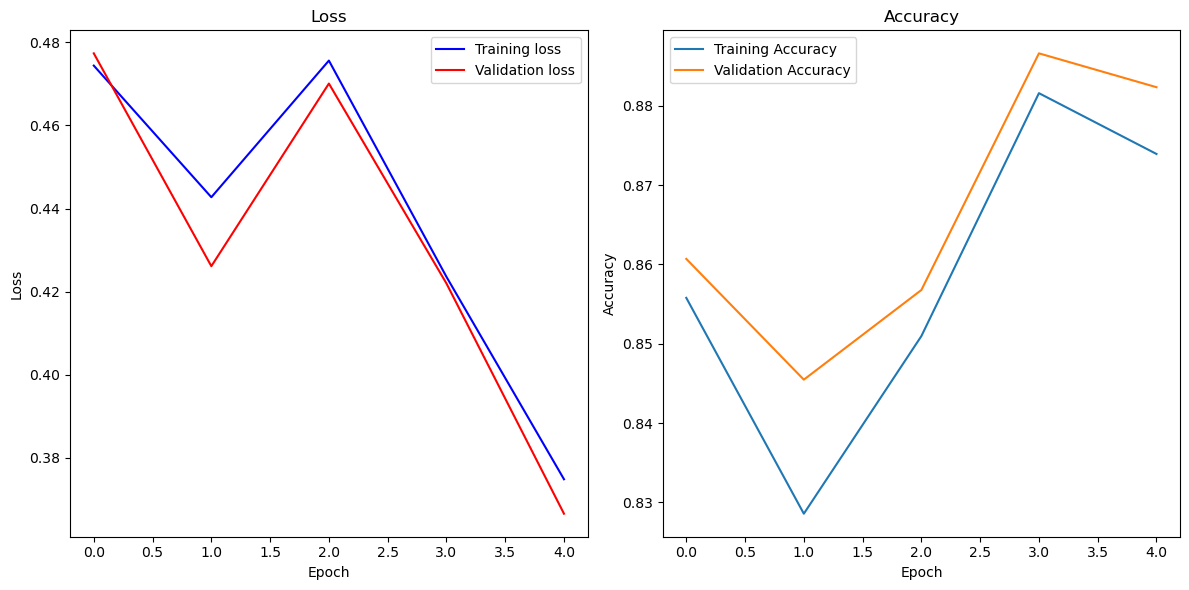

In [34]:
# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(train_loss_list, label='Training loss', color='blue')
ax[0].plot(val_loss_list, label='Validation loss', color='red')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracy_list, label='Training Accuracy')
ax[1].plot(val_accuracy_list, label='Validation Accuracy')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

Let's try on a test image

torch.Size([1, 2, 360, 480]) torch.Size([1, 360, 480]) torch.Size([3, 360, 480])


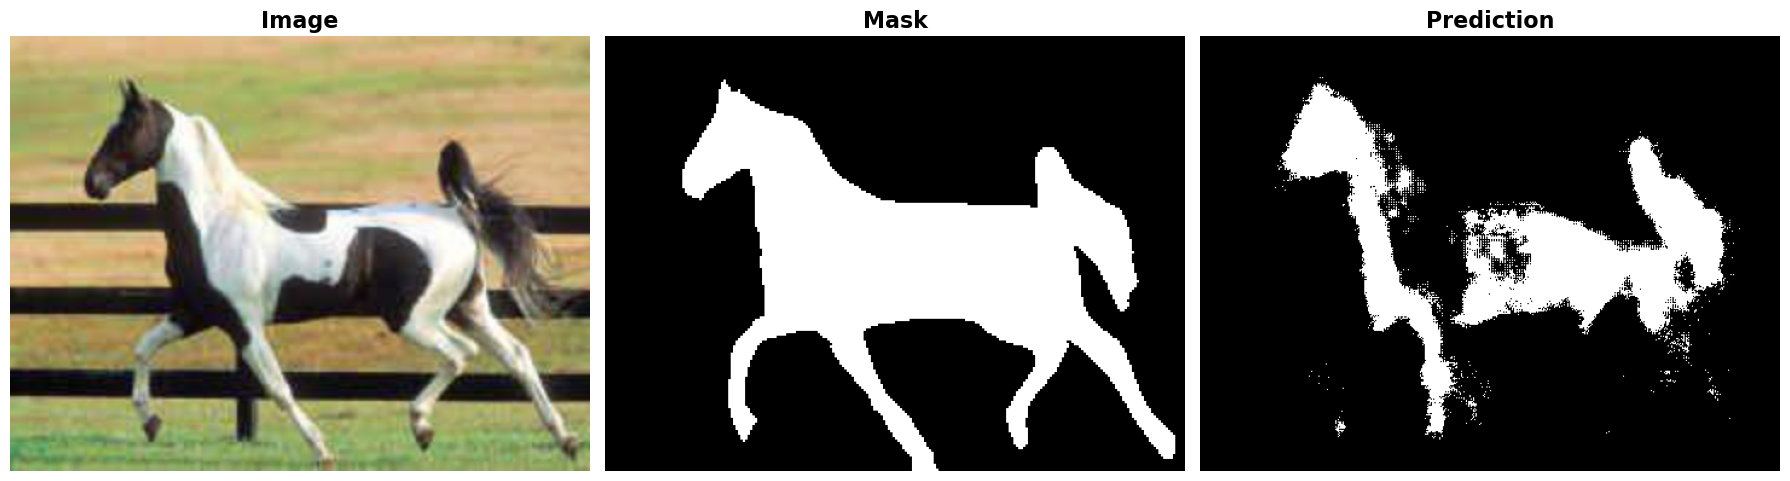

In [35]:
img, mask = test_resized_dataset[0]
img, mask = img.to(device), mask.to(device)
pred = model(img[None, ...])    # add a batch dimension


pred_bin = pred.argmax(1).float()       # binarize the prediction
pred_bin = pred_bin.squeeze()           # remove the batch dimension and the channel dimension

print(pred.shape, mask.shape, img.shape)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(img.cpu().permute(1, 2, 0))
ax[0].set_title('Image', fontsize=16, fontweight='bold')
ax[0].axis('off')

ax[1].imshow(mask.cpu().squeeze(), cmap='gray')
ax[1].set_title('Mask', fontsize=16, fontweight='bold')
ax[1].axis('off')

ax[2].imshow(pred_bin.cpu().detach(), cmap='gray')
ax[2].set_title('Prediction', fontsize=16, fontweight='bold')
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Altro (discarica)

#### Grid

Pseudo-grid search:

In [ ]:
lr_range = [1e-3, 1e-4, 1e-5],
EPOCHS = 10

for lr in lr_range:
    model = HorseshoeNetwork()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for t in range(EPOCHS):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test_loss, avg_accuracy = evaluate(test_dataloader, model, loss_fn)
        print(f"Test Error: \n Accuracy: {avg_accuracy}, Avg loss: {test_loss}")
    print("Done!")


#### Optuna

I want to try with Optuna. Because I don't have time for a full grid search...